In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import faiss
import os
from tqdm import tqdm

In [2]:
DATASET_PATH = "./../../datasets/clothing-dataset-small"
K = 8

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
def embed_image(image_path):
    img = Image.open(image_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = model.get_image_features(**inputs)
    emb = emb.cpu().numpy()
    emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    return emb[0]

In [5]:
# Build index
pants_imgs = [f"{DATASET_PATH}/train/pants/{x}" for x in os.listdir(f"{DATASET_PATH}/train/pants")]
shirt_imgs = [f"{DATASET_PATH}/train/shirt/{x}" for x in os.listdir(f"{DATASET_PATH}/train/shirt")]
catalog = pants_imgs + shirt_imgs
catalog = [(i, p) for i, p in enumerate(catalog)]

In [6]:
embs = []
for id_, path in tqdm(catalog):
    embs.append(embed_image(path))
embs = np.vstack(embs).astype('float32')
index = faiss.IndexFlatIP(embs.shape[1])  # inner-product on normalized vectors == cosine
index.add(embs)
# save index + mapping

100%|██████████| 758/758 [00:13<00:00, 58.27it/s]


In [7]:
def recommend(user_image_path, k=8):
    q = embed_image(user_image_path).astype('float32')
    D, I = index.search(q.reshape(1,-1), k)
    # I gives indices into 'catalog'
    return [catalog[i] for i in I[0]]

In [9]:
import random

val_paths = [
    f"{DATASET_PATH}/validation/pants/{x}" for x in os.listdir(f"{DATASET_PATH}/validation/pants/")
] + [
    f"{DATASET_PATH}/validation/shirt/{x}" for x in os.listdir(f"{DATASET_PATH}/validation/shirt/")
]

user_image_path = random.choice(val_paths)
recommendations = recommend(user_image_path, K)

In [10]:
recommendations

[(729,
  './../../datasets/clothing-dataset-small/train/shirt/006a85bc-8a95-4cd3-8c8c-215b53753abe.jpg'),
 (470,
  './../../datasets/clothing-dataset-small/train/shirt/ceb9e75d-b804-472e-9869-98b2c698b370.jpg'),
 (593,
  './../../datasets/clothing-dataset-small/train/shirt/0949e8e0-c807-4b6d-8453-80a05f1b733e.jpg'),
 (717,
  './../../datasets/clothing-dataset-small/train/shirt/9fdd7334-31fa-4038-a80d-456668fda43c.jpg'),
 (718,
  './../../datasets/clothing-dataset-small/train/shirt/ca5065aa-cb1f-45a0-9785-8a354aeb3b80.jpg'),
 (655,
  './../../datasets/clothing-dataset-small/train/shirt/b0c03127-9dfb-4573-8934-1958396937bf.jpg'),
 (598,
  './../../datasets/clothing-dataset-small/train/shirt/e1b266de-a3b0-4ff6-92c3-7302bc57b9cb.jpg'),
 (615,
  './../../datasets/clothing-dataset-small/train/shirt/ed9eb056-2f6b-4793-a045-33993416f4dd.jpg')]

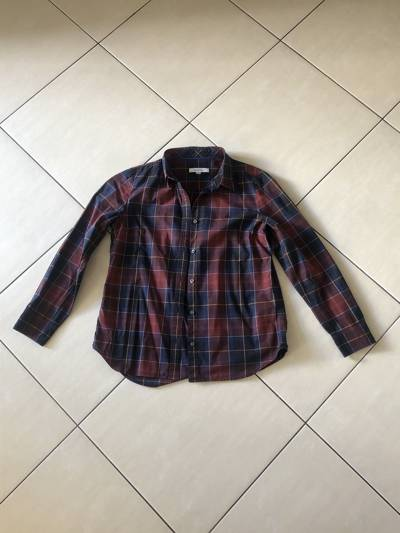

In [11]:
user_img = Image.open(user_image_path).convert("RGB")
user_img

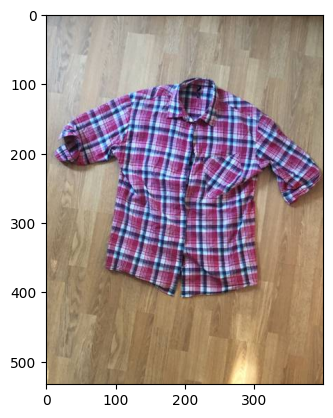

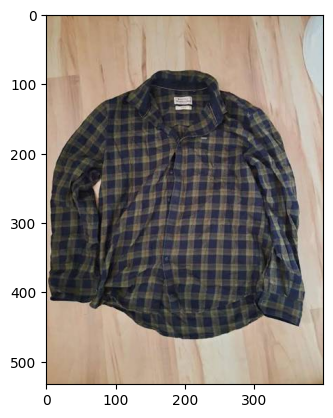

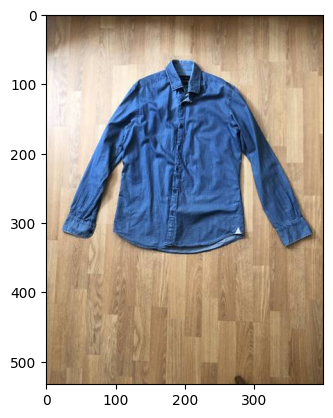

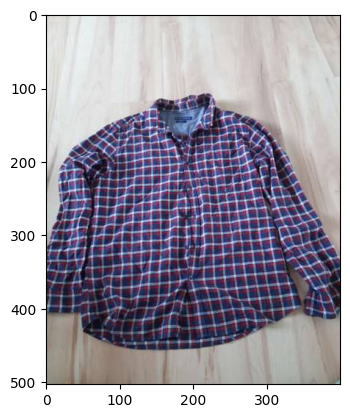

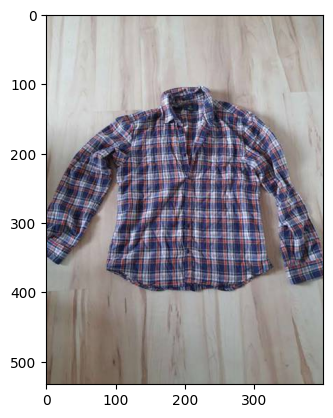

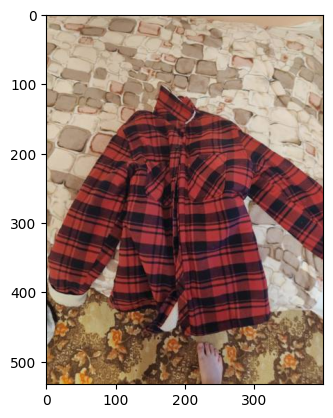

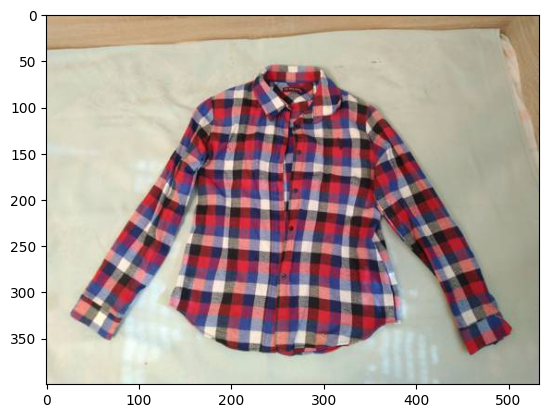

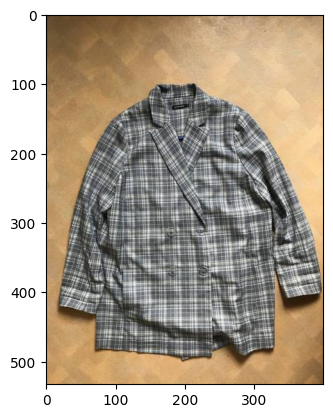

In [12]:
import matplotlib.pyplot as plt

for (_, x) in recommendations:
    img = Image.open(x).convert("RGB")
    plt.imshow(img)
    plt.show()

In [13]:
import cv2
import numpy as np
from PIL import Image

def simple_overlay(person_path, garment_path, garment_mask_path=None):
    person = cv2.imread(person_path, cv2.IMREAD_UNCHANGED)
    garment = cv2.imread(garment_path, cv2.IMREAD_UNCHANGED)  # RGBA ideally
    # detect torso bbox using e.g., simple heuristic or a keypoint detector
    # here: naively center garment on upper body; for demo use fixed scale
    ph, pw = person.shape[:2]
    gh, gw = garment.shape[:2]
    scale = 0.6  # tune
    new_w = int(pw * scale)
    new_h = int(gh * new_w / gw)
    garment_resized = cv2.resize(garment, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # compute position (example: center horizontally, at 25% from top)
    x = pw//2 - new_w//2
    y = int(ph*0.2)

    # If garment has alpha channel, use it as mask
    if garment_resized.shape[2] == 4:
        alpha = garment_resized[:,:,3]/255.0
        for c in range(3):
            person[y:y+new_h, x:x+new_w, c] = (alpha * garment_resized[:,:,c] +
                                               (1-alpha) * person[y:y+new_h, x:x+new_w, c])
    else:
        # fallback: simple overlay with constant alpha
        alpha = 0.8
        person[y:y+new_h, x:x+new_w,:3] = alpha*garment_resized[:,:,:3] + (1-alpha)*person[y:y+new_h, x:x+new_w,:3]

    plt.imshow(person)
    plt.show()

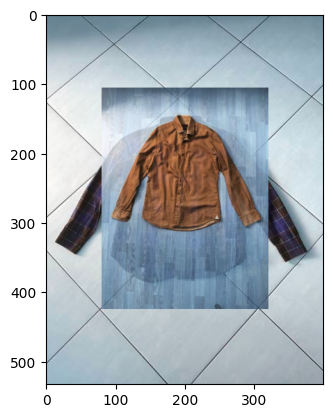

In [14]:
simple_overlay(user_image_path, recommendations[2][1])